# Türkiye'de Gelecek 18 Aydaki Enerji Fiyatlarının Projeksiyonu 
### Gelecek Piyasalarından Fiyatlar ile Türkiye'deki Gelecek 18 aydaki enerji fiyatlarının hesaplanması

**Barış Sanlı, barissanli2@gmail.com , http://barissanli.com**

Böyle bir çalışma Türkiye'de ilk defa kodları ile açık halde yapıldığından, referanslarken:

**Sanlı, B (2022) Türkiye 18 Aylık Gelecek Enerji Fiyatları (Version 1.0) , [Source Code], http://barissanli.com/calismalar/2022/tr_18ayenerjifiyatlari-bsanli.ipynb**

** İlgili makale : http://barissanli.com/calismalar/2022/20220203-tr_18ayenerjifiyatlari-bsanli.pdf **

Aşağıdaki kod ile Türkiye'deki 18 ay geleceğe doğru enerji fiyatlarının projeksiyonu yapılmaktadır.
Bu bir **TAHMİN** değildir. Sadece uluslararası enerji fiyatlarının gelecek vadeli son işlemlerinden yapılan bir hesaplamadır. Yani gelecek piyasalarındaki emtia fiyatlarının Türkiye fiyatlarına çevrimidir.

Kodu çalıştırdığınız her gün farklı fiyat oluşturacaktır. Çünkü bir önceki gün gelecek piyasalarında yapılan işlemlerden dolayı gelecek vade işlem fiyatları değişmiş olacaktır. 

Lisans CC BY-NC-SA (Ticari kullanım telife tabidir, ticari olmayan kullanım serbesttir)


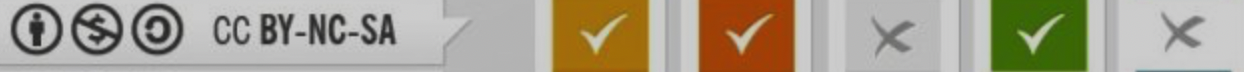

Başlamadan önce Financial Times'ın Lex köşesinden gelecek eğrilerinin öngörü olmadığı ile ilgili yazıyı mutlaka okuyun



All together now: “The forward curve is not a forecast”

But even a cursory review of the forward curve’s behaviour 
in recent years shows forward prices have been very poor 
predictors of realised spot values.

And the reason why futures are so poor at forecasting is
because the forward curve shows the price at which it is 
possible to buy or sell futures contracts for a forward 
date at a price agreed today.

It is not a forecast of future spot prices.




https://www.ft.com/content/946b0371-2515-38db-9f61-485e30de6e0b


In [2]:
%pylab inline
import requests
from numpy import array
import datetime  
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
pd.options.mode.chained_assignment = None

Verileri CME Group'un yayınladığı günlük verilerden çekiyorum. Ekteki gibi çağırınca son kapanış günü fiyatlarını veriyor

In [4]:
hh="https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/444/G"
ttf="https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/8378/G"
nbp="https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/8376/G"
jkm="https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/7049/G"
coal="https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/5951/G"
brent="https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/424/G"
tl="http://www.cmegroup.com/CmeWS/mvc/Quotes/Future/8582/G"

# cif med ulsd https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/5192/G?quoteCodes=&_=1603815060491
# european power https://www.cmegroup.com/trading/energy/european-power-futures.html
# fob med gasoline  https://www.cmegroup.com/trading/energy/refined-products/premium-unleaded-10-ppm-platts-fob-med-swap.html
# german baseload https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/8381/G
# german peak https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/8382/G

ulsd="https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/5192/G"
gasoline="https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/4571/G"
debaseload="https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/8381/G"
depeakload="https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/8382/G"

In [5]:
headers = requests.utils.default_headers()
headers.update(
    {
        'User-Agent': 'My User Agent 1.0',
    }
)

In [6]:
#HenryHub
r = requests.get(hh,headers=headers).json()
hh_price = pd.DataFrame([(item['expirationMonth'], item['priorSettle']) for item in r['quotes']],columns=['Date',"HH"])
#TTF 
r = requests.get(ttf,headers=headers).json()
ttf_price = pd.DataFrame([(item['expirationMonth'], item['priorSettle']) for item in r['quotes']],columns=['Date',"TTF"])
#JKM 
r = requests.get(jkm,headers=headers).json()
jkm_price = pd.DataFrame([(item['expirationMonth'], item['priorSettle']) for item in r['quotes']],columns=['Date',"JKM"])
#Coal
r = requests.get(coal,headers=headers).json()
coal_price = pd.DataFrame([(item['expirationMonth'], item['priorSettle']) for item in r['quotes']],columns=['Date',"CoalAPI2"])
#Brent
r = requests.get(brent,headers=headers).json()
brent_price = pd.DataFrame([(item['expirationMonth'], item['priorSettle']) for item in r['quotes']],columns=['Date',"Brent"])
#ULSD
r = requests.get(ulsd,headers=headers).json()
ulsd_price = pd.DataFrame([(item['expirationMonth'], item['priorSettle']) for item in r['quotes']],columns=['Date',"ULSD"])
#Gasoline
r = requests.get(gasoline,headers=headers).json()
gasoline_price = pd.DataFrame([(item['expirationMonth'], item['priorSettle']) for item in r['quotes']],columns=['Date',"Gasoline"])
#DE BaseLoad
r = requests.get(debaseload,headers=headers).json()
debaseload_price = pd.DataFrame([(item['expirationMonth'], item['priorSettle']) for item in r['quotes']],columns=['Date',"DE_BaseLoad"])
#ULSD 
r = requests.get(depeakload,headers=headers).json()
depeakload_price = pd.DataFrame([(item['expirationMonth'], item['priorSettle']) for item in r['quotes']],columns=['Date',"DE_PeakLoad"])
# https://www.theice.com/marketdata/DelayedMarkets.shtml?getHistoricalChartDataAsJson=&marketId=400187&historicalSpan=2

USDTRY kodunu ise bu satırda çekiyoruz. önce TRYUSD geliyor onu ters çevirerek USDTRY buluyoruz

In [7]:
r = requests.get(tl,headers=headers).json()
tl_price = [(item['expirationMonth'], item['priorSettle']) for item in r['quotes']]

In [8]:
tlf=pd.DataFrame(tl_price,columns=['Date',"TRYUSD"])
tlf=tlf[pd.to_numeric(tlf['TRYUSD'], errors='coerce').notnull()]
tlf.TRYUSD=tlf.TRYUSD.astype(float16)
tlf["USDTRY"]=1/tlf.TRYUSD

Şimdi tüm verileri bir araya getiriyoruz

In [9]:
dfs=[coal_price,brent_price,jkm_price,ttf_price,hh_price,ulsd_price,gasoline_price, debaseload_price, depeakload_price, tlf]

In [10]:
dfs = [df.set_index('Date') for df in dfs]
tot=dfs[0].join(dfs[1:])


Kodda en çok vakit kaybettiğim yer. ULSD (Dizel) ve Benzinde içeride kolonların bir yerinde "-" varmış onları kaldırıyoruz, sonra tüm tabloyu sayıya çeviriyoruz

In [11]:
tot[["ULSD","Gasoline"]]=tot[["ULSD","Gasoline"]].replace("-",np.nan)
tot=tot.apply(pd.to_numeric)

Şimdi Yahoo üzerinden bugün ki son Brent, TL, TTF ve HH (Henry Hub) fiyatlarını alarak güncel ay verisi olarak yerleştiriyoruz. Eğer **yfinance** kütüphanesi yok ise **!pip install yfinance** ile kurulabilir

In [1]:
# yfinance yok ise baştaki # kaldırarak aşağıdaki satırı çalıştırın
#!pip install yfinance

In [13]:
import yfinance as yf

In [14]:
from datetime import datetime,date,timedelta
endx=str((datetime.now()+timedelta(days=1)).strftime('%Y-%m-%d'))
startx=(date.today() + timedelta(days=-7)).strftime('%Y-%m-%d')

In [15]:
oil = yf.download("CL=F", start=startx,end=endx)
tryx = yf.download("USDTRY=X", start=startx,end=endx)
ttfx = yf.download("TTF=F", start=startx,end=endx)
hhx = yf.download("HH=F")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Doğrudan veri atamasında uyarı verdiği için bir de kodun uyarısız halini gösterme gereği duydum. Python da veri tablolarında veri kopyalamalarında bazı dikkat edilmesi gereken konular var. 

In [16]:
ilk=tot.index[0]
tot.loc[ilk,"Brent"]=oil.Close[-1].astype(float64);
tot.loc[ilk,"USDTRY"]=tryx.Close[-1];
tot.loc[ilk,"TTF"]=ttfx.Close[-1];
tot.loc[ilk,"HH"]=hhx.Close[-1];

# eski kod
#tot.Brent[0]=oil.Close[-1].astype(float64);
#tot.USDTRY[0]=tryx.Close[-1];
#tot.TTF[0]=ttfx.Close[-1];
#tot.HH[0]=hhx.Close[-1];

## Pratikte ham veri bu aşağıdaki satırda ve 5 yıl ileri doğru uzuyor


In [17]:
tot

,CoalAPI2,Brent,JKM,TTF,HH,ULSD,Gasoline,DE_BaseLoad,DE_PeakLoad,TRYUSD,USDTRY
Date,,,,,,,,,,,
FEB 2022,186.75,92.529999,NaN,70.918999,4.394,827.633,890.771,124.22,157.88,NaN,13.617188
MAR 2022,168.00,NaN,NaN,70.920000,4.306,814.304,889.969,154.45,191.08,0.072449,13.804688
APR 2022,155.00,93.280000,22.925,69.965000,4.241,796.358,890.304,162.81,190.40,NaN,NaN
MAY 2022,146.15,91.100000,23.015,69.330000,4.267,782.034,876.481,164.46,188.02,NaN,NaN
JUN 2022,142.20,89.290000,23.160,69.080000,4.312,770.614,860.654,170.76,197.55,0.068909,14.515625
JUL 2022,138.35,87.890000,23.380,68.970000,4.362,764.333,842.306,170.93,206.32,NaN,NaN
AUG 2022,134.60,86.830000,23.375,68.820000,4.372,760.464,825.623,167.74,197.00,NaN,NaN
SEP 2022,132.55,85.880000,23.570,68.905000,4.355,757.629,805.438,184.35,216.57,0.065063,15.367188
OCT 2022,130.55,85.020000,23.790,69.315000,4.378,752.667,780.906,179.80,235.01,NaN,NaN


Olmayan veri interpolasyon (alt ve üst satırlara göre yuvarlıyoruz) uyguluyoruz.

In [18]:
tot.USDTRY=tot.USDTRY.interpolate()
tot["Brent"]=tot.Brent.interpolate()
tot["JKM"]=tot.JKM.interpolate(limit_direction="backward")
tot=tot.astype(np.float16)
tot["TTF"]=tot["TTF"]/1.14 # Euro/MWh-> USD/MWh

In [19]:
tot

,CoalAPI2,Brent,JKM,TTF,HH,ULSD,Gasoline,DE_BaseLoad,DE_PeakLoad,TRYUSD,USDTRY
Date,,,,,,,,,,,
FEB 2022,186.7500,92.5000,22.921875,62.250000,4.394531,827.5,891.000,124.2500,157.8750,NaN,13.617188
MAR 2022,168.0000,92.8750,22.921875,62.250000,4.304688,814.5,890.000,154.5000,191.1250,0.072449,13.804688
APR 2022,155.0000,93.2500,22.921875,61.375000,4.242188,796.5,890.500,162.7500,190.3750,NaN,14.039062
MAY 2022,146.1250,91.1250,23.015625,60.812500,4.265625,782.0,876.500,164.5000,188.0000,NaN,14.281250
JUN 2022,142.2500,89.3125,23.156250,60.593750,4.312500,770.5,860.500,170.7500,197.5000,0.068909,14.515625
JUL 2022,138.3750,87.8750,23.375000,60.531250,4.363281,764.5,842.500,170.8750,206.3750,NaN,14.796875
AUG 2022,134.6250,86.8125,23.375000,60.375000,4.371094,760.5,825.500,167.7500,197.0000,NaN,15.085938
SEP 2022,132.5000,85.8750,23.562500,60.437500,4.355469,757.5,805.500,184.3750,216.6250,0.065063,15.367188
OCT 2022,130.5000,85.0000,23.796875,60.812500,4.378906,752.5,781.000,179.7500,235.0000,NaN,15.648438


In [20]:
tot.dtypes

CoalAPI2       float16
Brent          float16
JKM            float16
TTF            float16
HH             float16
ULSD           float16
Gasoline       float16
DE_BaseLoad    float16
DE_PeakLoad    float16
TRYUSD         float16
USDTRY         float16
dtype: object

Şimdi sadece 18 ayı alıyorum. Çünkü USD/TRY'de ötesinde işlem yok. İstesek uzatabiliriz. 

In [21]:
#del tot18
tot18=tot.iloc[0:18,:]

In [22]:
tot18.drop(columns=['TRYUSD'], inplace=True)

## Benzin ve Dizel hesabı

Bu hesapta bir kalibrasyon rakamı var. Türkiye'de ürünün üzerine rafineri marjı gibi konuları bilmediğimden bu kalibrasyon verisi ile son Ankara rakamlarına kalibre ediyorum

Vergi rakamları GIB.gov.tr 1 numaralı liste

In [23]:
# gib 1 sayılı liste
dizelOTV_TL=2.0559
benzinOTV_TL=2.0376
toptanci_USD=0.02
dagitici_USD=0.05
kdv=0.18
benzinlt=1/0.737 #kg
dizellt=1/0.832 #kg
#benzinlt=0.797 #kg
#dizellt=0.862 #kg
calibration_b=120
calibration_d=70

In [24]:
tot18["benzin_TL"]=(((((tot18.Gasoline+calibration_b)/(benzinlt*1000))+toptanci_USD+dagitici_USD)*tot18.USDTRY) + benzinOTV_TL)*(1+kdv)

tot18["dizel_TL"]=(((((tot18.ULSD+calibration_d)/(dizellt*1000))+toptanci_USD+dagitici_USD)*tot18.USDTRY) + dizelOTV_TL)*(1+kdv)

## İthal kömür ve Gaz hesabı

İthal kömür ton üzerinden, gaz fiyatları ise karışık. Ben bunun %80 petrol %20 TTF bazlı (LNG) gibi düşündüm birimler gaz da m3/TL, kömürde TL/ton

In [25]:
tot18["ithal_komur_TL"]=tot18.CoalAPI2*tot18.USDTRY*1.1*kdv
tot18["gaz_ithalat_TL"]=(0.80*(70+3*tot18.Brent)+0.20*(tot18.TTF*10))*tot18.USDTRY/1000
gaz_skb=0.3
gaz_otv=0.023
tot18["gaz_TL"]=(tot18["gaz_ithalat_TL"]+gaz_skb+gaz_otv)*(1+kdv)

## Elektrik üretimi için Gaz ve Kömür

Buradaki hesapta MWh başına TL fiyatlar hesaplanıyor. Petrolde daha önce yaptığım çalışmalardan 3\*brent+70 gibi bir formül tercih ettim. Dünya Bankası Pink Sheet'te Almanya teslim Rus gaz fiyatı için yaklaşım sağlıyor

In [26]:
tot18["gazdan_elektrik_TL"]= ((0.80*(70+3*tot18.Brent)/10+0.20*(tot18.TTF))/0.5)*tot18.USDTRY

In [27]:
tot18["komurden_elektrik_TL"]= ((tot.CoalAPI2/7)/0.4)*tot18.USDTRY

Gün öncesi fiyatları (GOP-piyasası) için gaz veya kömürden her satırda yüksek olanı seçiyor
Sonra elektrik fiyatlarını hesaplarken, diğer bedellerin 4 cent civarında olacağını öngörüp, ona kdv ekliyor

In [28]:
tot18["GOP_TL"]=tot18[["gazdan_elektrik_TL","komurden_elektrik_TL"]].max(axis=1)*1.1
tot18["elektrik_TL"]=(tot18["GOP_TL"]/1000+tot18.USDTRY*0.045)*(1+kdv)

İşte fiyat tablosu

In [29]:
tot18[["Brent","Gasoline","TTF","CoalAPI2","USDTRY","benzin_TL","dizel_TL",
       "gaz_TL","elektrik_TL","gazdan_elektrik_TL","komurden_elektrik_TL","GOP_TL"]]

,Brent,Gasoline,TTF,CoalAPI2,USDTRY,benzin_TL,dizel_TL,gaz_TL,elektrik_TL,gazdan_elektrik_TL,komurden_elektrik_TL,GOP_TL
Date,,,,,,,,,,,,
FEB 2022,92.5000,891.0,62.25000,186.7500,13.617188,15.492188,15.539062,6.847540,2.144996,1096.0,908.0,1205.0
MAR 2022,92.8750,890.0,62.25000,168.0000,13.804688,15.656250,15.546875,6.951379,2.177787,1113.0,828.5,1224.0
APR 2022,93.2500,890.5,61.37500,155.0000,14.039062,15.898438,15.523438,7.050499,2.212306,1130.0,777.5,1243.0
MAY 2022,91.1250,876.5,60.81250,146.1250,14.281250,15.953125,15.546875,7.059939,2.227918,1132.0,745.5,1245.0
JUN 2022,89.3125,860.5,60.59375,142.2500,14.515625,15.968750,15.593750,7.088260,2.245918,1137.0,738.0,1250.0
JUL 2022,87.8750,842.5,60.53125,138.3750,14.796875,16.015625,15.757812,7.149620,2.275058,1148.0,731.5,1262.0
AUG 2022,86.8125,825.5,60.37500,134.6250,15.085938,16.046875,15.960938,7.234580,2.309495,1162.0,725.5,1278.0
SEP 2022,85.8750,805.5,60.43750,132.5000,15.367188,16.031250,16.171875,7.324259,2.343355,1177.0,727.0,1294.0
OCT 2022,85.0000,781.0,60.81250,130.5000,15.648438,15.953125,16.343750,7.423379,2.380756,1194.0,729.5,1313.0


## Gelecek eğrileri

İstersek gelecek eğrilerinin Türkiye versiyonlarını da çizdirebiliriz


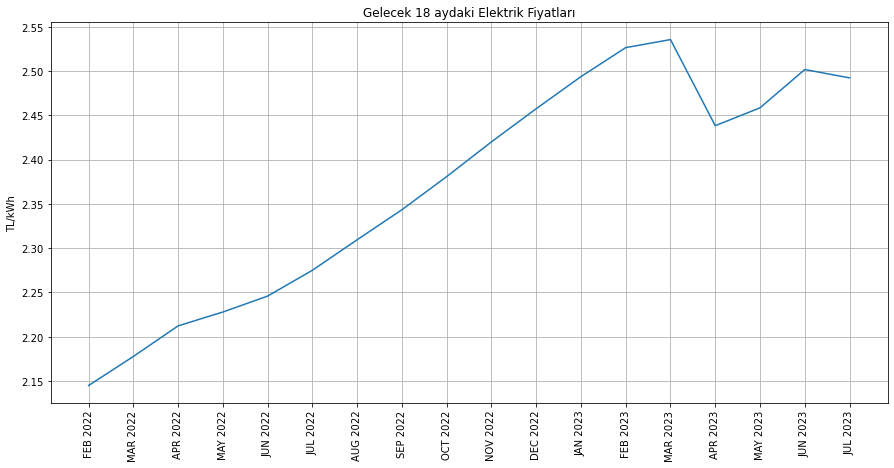

In [30]:
figure(figsize=(15,7))
ylabel("TL/kWh")
title("Gelecek 18 aydaki Elektrik Fiyatları")
plot(tot18.elektrik_TL)
xticks(rotation=90)
grid()

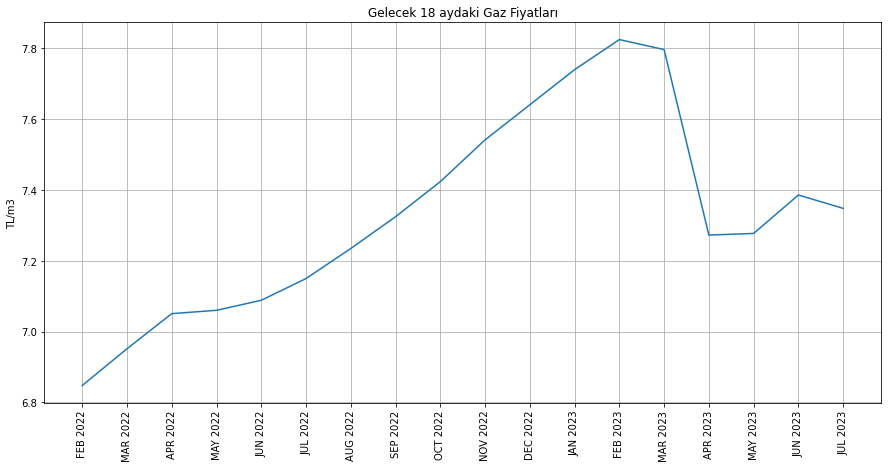

In [31]:
figure(figsize=(15,7))
ylabel("TL/m3")
title("Gelecek 18 aydaki Gaz Fiyatları")
plot(tot18.gaz_TL)
xticks(rotation=90)
grid()

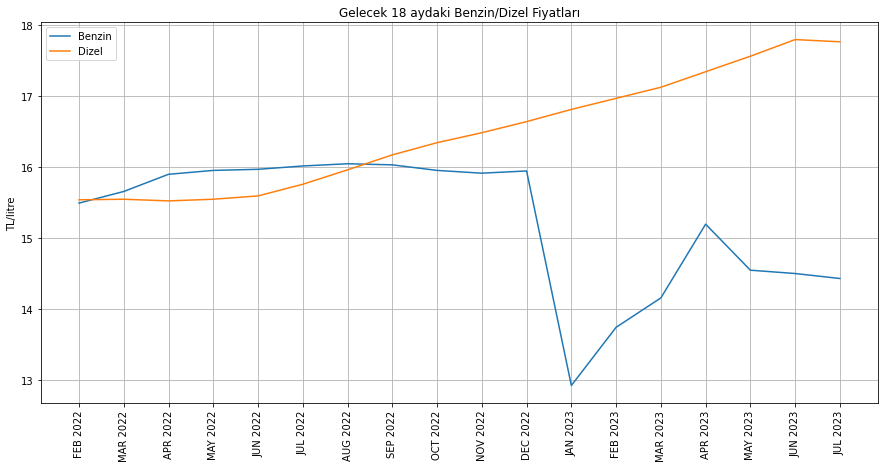

In [32]:
figure(figsize=(15,7))


ylabel("TL/litre")
title("Gelecek 18 aydaki Benzin/Dizel Fiyatları")
plot(tot18.benzin_TL, label="Benzin")
plot(tot18.dizel_TL,label="Dizel")
xticks(rotation=90)
grid()
legend()

In [33]:
tot18[["benzin_TL","dizel_TL","gaz_TL","elektrik_TL"]].diff(6)

,benzin_TL,dizel_TL,gaz_TL,elektrik_TL
Date,,,,
FEB 2022,NaN,NaN,NaN,NaN
MAR 2022,NaN,NaN,NaN,NaN
APR 2022,NaN,NaN,NaN,NaN
MAY 2022,NaN,NaN,NaN,NaN
JUN 2022,NaN,NaN,NaN,NaN
JUL 2022,NaN,NaN,NaN,NaN
AUG 2022,0.554688,0.421875,0.38704,0.164499
SEP 2022,0.375000,0.625000,0.37288,0.165569
OCT 2022,0.054688,0.820312,0.37288,0.168450


In [34]:
tot18[["benzin_TL","dizel_TL","gaz_TL","elektrik_TL"]].diff(10)

,benzin_TL,dizel_TL,gaz_TL,elektrik_TL
Date,,,,
FEB 2022,NaN,NaN,NaN,NaN
MAR 2022,NaN,NaN,NaN,NaN
APR 2022,NaN,NaN,NaN,NaN
MAY 2022,NaN,NaN,NaN,NaN
JUN 2022,NaN,NaN,NaN,NaN
JUL 2022,NaN,NaN,NaN,NaN
AUG 2022,NaN,NaN,NaN,NaN
SEP 2022,NaN,NaN,NaN,NaN
OCT 2022,NaN,NaN,NaN,NaN


- 900 milyon kWh elektrik,
- 250 milyon m3 doğalgaz,
- 50 milyon litre dizel
- 10 milyon litre benzin

In [35]:
kalan_gun= 365-31
elektrik_maliyeti= kalan_gun*0.9*0.38 /2 # milyar tl
gaz_maliyeti=kalan_gun*1.066*0.25 /2 #milyar tl
benzin_maliyeti=kalan_gun*0.726562*0.01 /2
dizel_maliyeti=kalan_gun*1.242*0.05 /2
toplam_maliyet= elektrik_maliyeti+gaz_maliyeti+benzin_maliyeti+dizel_maliyeti

In [36]:
toplam_maliyet

113.20355854000002

In [37]:
print("Elektrik maliyeti : ",elektrik_maliyeti)
print("Gaz maliyeti : ",gaz_maliyeti)
print("Benzin maliyeti : ",benzin_maliyeti)
print("Dizel maliyeti : ",dizel_maliyeti)
print("Toplam maliyet : ",toplam_maliyet ,"  milyar TL")

Elektrik maliyeti :  57.114000000000004
Gaz maliyeti :  44.505500000000005
Benzin maliyeti :  1.2133585400000002
Dizel maliyeti :  10.3707
Toplam maliyet :  113.20355854000002   milyar TL
